In [30]:
import torch,json,os,importlib

Download the pretrained models from https://zenodo.org/record/4282667 and extract the models directories into the "pretrained_models" directory.



In [2]:
os.listdir("pretrained_models/")

['ensem3',
 'sub2',
 '.gitignore',
 'sub1',
 'sub3',
 'ensem2',
 'ensem1',
 'README.md']

# Select the pretrained model path

In [3]:
#model_path="pretrained_models/sub1/"
model_path="pretrained_models/single_resnet"
model_path="pretrained_models/sub2"
#model_path="pretrained_models/sub3/"

# Loading the model specified by model_path

In [4]:
os.listdir(model_path)

['eval_predictions_probs.pth',
 'eval_predictions.csv',
 'model_config.json',
 'dataset_config.json',
 'model_from_training_state_dict.pth',
 'description.txt',
 'model_state_dict.pth']

### Loading the model config from json

In [5]:
with open(model_path+'/model_config.json',"r")as f:
    model_config=json.load(f)

### Making an instance

In [6]:
module = importlib.import_module('models.{}'.format(model_config['arch']))
Network = getattr(module, 'Network')
model=Network(model_config)

n_blocks_per_stage is specified ignoring the depth param, nc=None



Warning Pruning only 1x1 CONVS

0 0.05892556509887896 0.408248290463863
1 0.05892556509887896 0.408248290463863
2 0.05892556509887896 0.408248290463863
3 0.1767766952966369 0.408248290463863
4 0.125 0.408248290463863
5 0.125 0.408248290463863


### Loading the pretrained weights

In [7]:
state_dict=torch.load(model_path+"/model_state_dict.pth")

In [17]:
print(type(state_dict))
print(state_dict)

<class 'collections.OrderedDict'>
OrderedDict([('in_c.0.weight', tensor([[[[-0.1429, -0.0648,  0.0114,  0.0569, -0.0784],
          [-0.0733,  0.1440,  0.0124, -0.0848, -0.0826],
          [ 0.0959,  0.0906, -0.0935,  0.0918,  0.1566],
          [-0.1307,  0.0622,  0.0159,  0.0644,  0.0370],
          [-0.0991, -0.1321,  0.0168,  0.0773,  0.0294]],

         [[-0.1445, -0.0134, -0.0107,  0.1593,  0.0876],
          [-0.0663,  0.0102,  0.1387, -0.0341,  0.0398],
          [ 0.0134, -0.0481, -0.1199,  0.0844,  0.1439],
          [-0.1630, -0.1382,  0.0583,  0.0310, -0.0373],
          [ 0.0770, -0.0646, -0.1075,  0.1564, -0.0600]]],


        [[[ 0.0513,  0.0703, -0.0004, -0.0576, -0.1503],
          [ 0.1017,  0.0812,  0.1875,  0.0679, -0.1342],
          [-0.0854, -0.0377, -0.1177, -0.1555, -0.0812],
          [ 0.1257,  0.1068,  0.0574,  0.1015, -0.0876],
          [ 0.0634, -0.0325,  0.0237, -0.0309, -0.0534]],

         [[-0.0514,  0.0397, -0.0061,  0.0411,  0.0338],
          [-0.0

In [8]:
# if the weights are float16 cast the model
if [v for k,v in state_dict.items()][0].dtype==torch.float16:
    model=model.half()
    print("model in float16")
model.load_state_dict(state_dict)


model in float16


<All keys matched successfully>

In [9]:
model=model.cuda()

### Parameters count


In [10]:
def count_non_zero_params_nonbn(model):
    sum_params = 0
    sum_non_zero= 0 
    desc=""
    def calc_params(model):
        nonlocal desc, sum_params, sum_non_zero
        skip="count"
        if "batchnorm" in  type(model).__name__.lower():
            skip="skip"
        for k,p in model.named_parameters(recurse=False):
            if p.requires_grad:
                nonzero = (p != 0).sum()
                total= p.numel()
                desc += f"type {type(model).__name__}, {k},  {total}, {nonzero}, {p.dtype}, {skip} " + "\n"
                if skip!="skip":
                    sum_params+=total
                    sum_non_zero+=nonzero
    model.apply(calc_params)       
    return desc,sum_params,sum_non_zero

In [11]:
desc,sum_params,sum_non_zero=count_non_zero_params_nonbn(model)
print("Total: ",sum_params, "Non-Zero:",sum_non_zero)
print(desc)

Total:  343552 Non-Zero: tensor(247562, device='cuda:0')
type Conv2d, weight,  3200, 3200, torch.float16, count 
type BatchNorm2d, weight,  64, 64, torch.float16, skip 
type BatchNorm2d, bias,  64, 64, torch.float16, skip 
type Conv2dDamped, weight,  36864, 36864, torch.float16, count 
type BatchNorm2d, weight,  64, 64, torch.float16, skip 
type BatchNorm2d, bias,  64, 64, torch.float16, skip 
type Conv2dPrune, weight,  4096, 2698, torch.float16, count 
type Conv2dPrune, prune_mask,  4096, 0, torch.float16, count 
type BatchNorm2d, weight,  64, 64, torch.float16, skip 
type BatchNorm2d, bias,  64, 64, torch.float16, skip 
type Conv2dDamped, weight,  36864, 36864, torch.float16, count 
type BatchNorm2d, weight,  64, 64, torch.float16, skip 
type BatchNorm2d, bias,  64, 64, torch.float16, skip 
type Conv2dDamped, weight,  36864, 36864, torch.float16, count 
type BatchNorm2d, weight,  64, 64, torch.float16, skip 
type BatchNorm2d, bias,  64, 64, torch.float16, skip 
type Conv2dDamped, wei

# Loading DataSet

In [30]:
import datasets
print(os.getcwd())
# the eval json config dataset specifies that the norms should be calculated from all the training clips. 
with open('configs/datasets/dcase2020b.json',"r")as f:
    dataset_config=json.load(f)

print(dataset_config)
datasetm=datasets.DatasetsManager(dataset_config['audiodataset'])

/mounts/ud3/contractors/jtaylor/acoustic_scene_classification/RFR-CNN-2020
{'audiodataset': {'sub_parser': 'nolabel_csv', 'subsample': False, 'stereo_desync': False, 'no_resample': False, 'spec_resize': False, 'resize_limit_t': 26, 'stereo_flip': False, 'dcace_version': None, 'leaderboard_audio_path': 'datasets/TAU-urban-acoustic-scenes-2019-leaderboard/', 'cache_x_name': '', 'audio_path': 'datasets/TAU-urban-acoustic-scenes-2020-3class-development/', 'leaderboard_parser': 'nolabel_csv', 'sub_audio_path': 'datasets/TAU-urban-acoustic-scenes-2020-3class-evaluation/', 'audio_processor': 'd18_stereo', 'parser': 'categorical_csv', 'resize_limit': 26, 'use_as_default_scaler': False, 'vertical_desync': False, 'name': 'd20t1b', 'train_files_csv': 'datasets/TAU-urban-acoustic-scenes-2020-3class-development/evaluation_setup/fold{}_train.csv', 'file_cache': True, 'fold': 1, 'normalize': 1, 'leaderboard_parser_args': {'files_col': 0, 'header': 0, 'csv_file': 'datasets/evaluation_setup/test.csv'},

In [31]:
trainds=datasetm.get_train_set()
testds=datasetm.get_train_set()
evalds=datasetm.get_sub_dataset()

normalized train!
normalized train!
normalized test!
normalized SUB dataset!


## Sanity checks

### dev train

In [15]:
all_y=0
corr_y=0
model.eval()
model.cuda()
half_mode=True
data_loader = torch.utils.data.DataLoader(trainds,
                                          batch_size=1,
                                          shuffle=False)
with torch.no_grad():
    for i,(x,idx,y) in enumerate(data_loader):
        if i%10==0:
            print(i,"/",len(data_loader),end="\r")
        x=x.cuda()
        if half_mode:
            x=x.half()
        out=model(x)
        all_y+=1
        print(out, y)
        corr_y+=(torch.argmax(out).cpu()==y).sum().item()
print("all ", all_y," correct ",corr_y," ratio=",corr_y*1./all_y) 


    

tensor([[ 5.6172, -1.3486, -5.2852]], device='cuda:0', dtype=torch.float16) tensor([0])
tensor([[-2.5762, -3.2754,  4.6055]], device='cuda:0', dtype=torch.float16) tensor([2])
tensor([[ 5.3477, -0.9854, -5.1250]], device='cuda:0', dtype=torch.float16) tensor([0])
tensor([[-2.5625,  6.8867, -3.1816]], device='cuda:0', dtype=torch.float16) tensor([1])
tensor([[-1.5889,  5.8320, -4.0039]], device='cuda:0', dtype=torch.float16) tensor([1])
tensor([[-3.8320,  7.0000, -3.2148]], device='cuda:0', dtype=torch.float16) tensor([1])
tensor([[ 3.0215, -0.9756, -3.0254]], device='cuda:0', dtype=torch.float16) tensor([0])
tensor([[-3.1973,  6.3828, -2.6836]], device='cuda:0', dtype=torch.float16) tensor([1])
tensor([[ 0.6597,  4.0781, -4.5352]], device='cuda:0', dtype=torch.float16) tensor([0])
tensor([[ 3.5156,  0.7544, -4.7695]], device='cuda:0', dtype=torch.float16) tensor([0])
tensor([[ 3.4043, -0.0574, -4.4648]], device='cuda:0', dtype=torch.float16) tensor([0])
tensor([[-1.0957,  6.4219, -5.78

tensor([[-3.1426, -2.5781,  5.0000]], device='cuda:0', dtype=torch.float16) tensor([2])
tensor([[ 5.1875, -1.9678, -3.8672]], device='cuda:0', dtype=torch.float16) tensor([0])
tensor([[-3.2266,  6.5742, -3.8379]], device='cuda:0', dtype=torch.float16) tensor([1])
tensor([[-1.1172, -4.6250,  4.8242]], device='cuda:0', dtype=torch.float16) tensor([2])
tensor([[-4.8750,  5.7969, -0.4241]], device='cuda:0', dtype=torch.float16) tensor([1])
tensor([[ 4.7500, -0.6772, -4.6953]], device='cuda:0', dtype=torch.float16) tensor([0])
tensor([[-3.9043,  7.5469, -3.9414]], device='cuda:0', dtype=torch.float16) tensor([1])
tensor([[-1.0840, -3.3770,  4.1875]], device='cuda:0', dtype=torch.float16) tensor([2])
tensor([[ 1.6631,  1.3789, -3.6465]], device='cuda:0', dtype=torch.float16) tensor([0])
tensor([[-2.9121, -2.6562,  4.7539]], device='cuda:0', dtype=torch.float16) tensor([2])
tensor([[-2.6660,  6.3203, -3.7363]], device='cuda:0', dtype=torch.float16) tensor([1])
tensor([[ 4.9102, -1.5859, -3.93

In [10]:
# for i,(x,idx,y) in enumerate(data_loader):
#     print(y)

print(len(data_loader))

NameError: name 'data_loader' is not defined

# eval

In [35]:
all_y=0
corr_y=0
model.eval()
model.cuda()
half_mode=True
data_loader = torch.utils.data.DataLoader(evalds,
                                          batch_size=1,
                                          shuffle=False,num_workers=10)
preds=[]
file_names=[]
with torch.no_grad():
    for i,(x,idx,y) in enumerate(data_loader):
        if i%10==0:
            print(i,"/",len(data_loader),end="\r")
        x=x.cuda()
        if half_mode:
            x=x.half()
        out=model(x)
        all_y+=1
        file_names+=[a for a in idx]
        preds+=[out.cpu()]
print("all ", all_y," correct ",corr_y," ratio=",corr_y*1./all_y) 
    

Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f19a0cfa6d8>>Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f19a0cfa6d8>><bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f19a0cfa6d8>><bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f19a0cfa6d8>>
<bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f19a0cfa6d8>>
Exception ignored in: 
Traceback (most recent call last):


Traceback (most recent call last):
Traceback (most recent call last):
  File "/work/contractors/jtaylor/.conda/envs/cp

all  8640  correct  0  ratio= 0.0


In [37]:
pfiles,pprobs=torch.load(model_path+"/eval_predictions_probs.pth")

In [47]:
pfiles==file_names
print(len(pfiles))
print(pprobs)
print(preds)

8640
tensor([[-2.9375, -3.3262,  4.5156],
        [-4.3516, -2.0957,  6.3203],
        [ 4.4180, -1.2285, -3.6074],
        ...,
        [-2.4570,  5.1602, -2.7305],
        [ 4.1602, -3.5254, -2.0898],
        [-0.9619, -3.4180,  3.2773]], dtype=torch.float16)


[tensor([[-2.3125, -3.1934,  3.9395]], dtype=torch.float16), tensor([[-3.8633, -1.8164,  5.9531]], dtype=torch.float16), tensor([[ 1.4883,  2.0547, -3.4531]], dtype=torch.float16), tensor([[-2.7441,  6.4258, -3.7305]], dtype=torch.float16), tensor([[-0.6929,  4.5391, -3.7676]], dtype=torch.float16), tensor([[-0.0504,  2.4297, -1.9795]], dtype=torch.float16), tensor([[-2.4902, -0.0789,  1.8457]], dtype=torch.float16), tensor([[-3.2051, -1.1611,  4.3125]], dtype=torch.float16), tensor([[-2.5215,  6.1680, -3.3652]], dtype=torch.float16), tensor([[-3.1836,  5.5625, -2.0156]], dtype=torch.float16), tensor([[-2.2871,  3.9863, -2.2715]], dtype=torch.float16), tensor([[-1.0078,  4.6367, -3.1797]], dtype=torch.float16), tensor([[ 1.1680,  3.5684, -3.8809]], dtype=torch.float16), tensor([[-1.6328,  5.3047, -3.2363]], dtype=torch.float16), tensor([[-2.9785, -3.1719,  4.4531]], dtype=torch.float16), tensor([[-2.9746,  6.2070, -2.9922]], dtype=torch.float16), tensor([[ 0.0806, -2.9375,  2.0918]], d

In [39]:
print("matching",(torch.argmax(pprobs.float(),1)== torch.argmax(torch.cat(preds,0).float(),1) ).sum(),"out of " ,pprobs.shape[0])


matching tensor(7424) out of  8640


# ATTEMPT AT 2019

In [1]:
from __future__ import print_function

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import argparse
import datetime
import shutil
import time
import random
import json
import torch,json,os,importlib

from trainer import Trainer
import utils_funcs
import traceback
import pprint

/work/contractors/jtaylor/.conda/envs/cpjku_dcase19/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
epochs = 400
rho = 5
mixup = 1
load = '/work/contractors/jtaylor/acoustic_scene_classification/RFR-CNN-2019/pretrained_models/single_resnet/last_model_300.pth'

with open("configs/cp_resnet_eval.json", "r") as text_file:
    default_conf = json.load(text_file)

print(default_conf)
default_conf['out_dir'] = default_conf['out_dir'] + str(datetime.datetime.now().strftime('%b%d_%H.%M.%S'))
tensorboard_write_path = default_conf['out_dir'].replace("out", "runs", 1)

print("The experiment tesnorboard can be accessed: tensorboard --logdir  ", tensorboard_write_path)
print("Rho value : ", rho)
print("Use Mix-up : ", mixup)

from models.cp_resnet import get_model_based_on_rho
default_conf['model_config'] = get_model_based_on_rho(rho, "cp_resnet", config_only=True)
pprint.pprint(default_conf)

{'arch': 'cp_resnet', 'audiodataset': {'audio_path': 'datasets/TAU-urban-acoustic-scenes-2019-development/', 'audio_processor': 'd18_stereo', 'cache': True, 'cache_x_name': '', 'cv_version': None, 'dcace_version': None, 'file_cache': True, 'fold': 1, 'leaderboard_audio_path': 'datasets/TAU-urban-acoustic-scenes-2019-leaderboard/', 'leaderboard_parser': 'nolabel_csv', 'leaderboard_parser_args': {'csv_file': 'datasets/TAU-urban-acoustic-scenes-2019-leaderboard/evaluation_setup/test.csv', 'files_col': 0, 'header': 0}, 'name': 'd19t1', 'no_resample': False, 'normalize': 1, 'num_of_classes': 10, 'parser': 'categorical_csv', 'parser_args': {'csv_file': 'datasets/TAU-urban-acoustic-scenes-2019-development/meta.csv', 'files_col': 0, 'header': 0, 'labels_col': 1}, 'resize_limit': 26, 'resize_limit_t': 26, 'roll': 1, 'scale': False, 'spec_resize': False, 'stereo_desync': False, 'stereo_flip': False, 'sub_audio_path': 'datasets/TAU-urban-acoustic-scenes-2019-evaluation/', 'sub_parser': 'nolabel_c

In [3]:
try:
    # set utils_funcs.model_config to the current model (not safe with lru)
    utils_funcs.model_config = default_conf['model_config']
    _, max_rf = utils_funcs.get_maxrf(24)
    print("For this Rho, the maximium RF is: ", max_rf)
except:
    print("couldn't determine the max RF, maybe non-standard model_config")
    traceback.print_exc()

if mixup:
    default_conf['use_mixup'] = True
    default_conf['loss_criterion'] = 'mixup_default'
else:
    default_conf['use_mixup'] = False

For this Rho, the maximium RF is:  81


In [4]:
# Trying to load in one of my previous predictions from 2019
import datasets
#print(os.getcwd())

# the eval json config dataset specifies that the norms should be calculated from all the training clips. 
with open('configs/datasets/dcase2019.json',"r") as f:
    dataset_config=json.load(f)

#print(dataset_config)
#print(dataset_config['audiodataset'])
datasetm=datasets.DatasetsManager(dataset_config['audiodataset'])

trainds=datasetm.get_train_set()
testds=datasetm.get_test_set()
evalds=datasetm.get_sub_dataset()

epochs = epochs
#print(default_conf)
trainer = Trainer(default_conf)

d19t1 datasets/TAU-urban-acoustic-scenes-2019-development/evaluation_setup/fold{}_train.csv
loading dataset from 'd19t1'
normalizing dataset
normalized train!
attempting to load x from cache at datasets/cached_datasets/d19t1/tr_mean_452f8f_f1_apd18_stereo_obj.pt...
loaded datasets/cached_datasets/d19t1/tr_mean_452f8f_f1_apd18_stereo_obj.pt from cache in 0.0012857913970947266 
attempting to load x from cache at datasets/cached_datasets/d19t1/tr_std_452f8f_f1_apd18_stereo_obj.pt...
loaded datasets/cached_datasets/d19t1/tr_std_452f8f_f1_apd18_stereo_obj.pt from cache in 0.000978708267211914 
normalized test!
normalized test!
normalized SUB dataset!
datasets/TAU-urban-acoustic-scenes-2019-development/
loading dataset from 'd19t1_sub'
0.0
Network(
  (in_c): Sequential(
    (0): Conv2d(2, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (stage1): Sequ

Trainable model parameters 3566612, non-trainable 0 
Trainable model parameters non-zero 1915018 
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: [0.9, 0.999]
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)
normalized test!
d19t1 datasets/TAU-urban-acoustic-scenes-2019-development/evaluation_setup/fold{}_train.csv
normalized train!
normalized test!
normalized SUB dataset!
datasets/TAU-urban-acoustic-scenes-2019-evaluation/


In [10]:
data_loader = torch.utils.data.DataLoader(testds,
                                          batch_size=1,
                                          shuffle=False)
print(len(data_loader))

preds=[]
file_names=[]
y_list=[]
with torch.no_grad():
    for i,(x,idx,y) in enumerate(data_loader):
        y_list.append(y)
        if i%10==0:
            print(i,"/",len(data_loader),end="\r")

print(len(y_list))

4185


/work/contractors/jtaylor/.conda/envs/cpjku_dcase19/lib/python3.6/site-packages/librosa/core/convert.py:1336: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])


4185 / 4185


In [63]:
len(y_list)
print(y_list)

[tensor([7]), tensor([2]), tensor([4]), tensor([7]), tensor([8]), tensor([3]), tensor([5]), tensor([0]), tensor([3]), tensor([8]), tensor([0]), tensor([0]), tensor([7]), tensor([0]), tensor([3]), tensor([6]), tensor([1]), tensor([5]), tensor([3]), tensor([7]), tensor([3]), tensor([7]), tensor([1]), tensor([2]), tensor([9]), tensor([6]), tensor([9]), tensor([4]), tensor([4]), tensor([1]), tensor([3]), tensor([4]), tensor([9]), tensor([0]), tensor([0]), tensor([7]), tensor([1]), tensor([7]), tensor([4]), tensor([1]), tensor([9]), tensor([5]), tensor([8]), tensor([1]), tensor([4]), tensor([4]), tensor([5]), tensor([1]), tensor([9]), tensor([0]), tensor([6]), tensor([6]), tensor([2]), tensor([2]), tensor([4]), tensor([2]), tensor([0]), tensor([2]), tensor([7]), tensor([9]), tensor([6]), tensor([3]), tensor([6]), tensor([7]), tensor([3]), tensor([2]), tensor([1]), tensor([8]), tensor([4]), tensor([4]), tensor([8]), tensor([7]), tensor([2]), tensor([6]), tensor([3]), tensor([2]), tensor([0])

In [13]:
sids, probs = torch.load('/work/contractors/jtaylor/acoustic_scene_classification/RFR-CNN-2019/2023-10-31 14:28:58.367282eval_predictions.pth')

In [64]:
print(probs)
y_pred_val = np.array([int(torch.argmax(prediction)) for prediction in probs])
print(len(y_pred_val), y_pred_val)

y_val_labels = np.array([int(y) for y in y_list][0:4180])
print(len(y_val_labels), y_val_labels)



tensor([[-0.7399, -2.0667, -2.5726,  ...,  5.8837,  0.6111, -2.6087],
        [-1.2863,  0.0663,  7.9030,  ..., -2.1543, -1.0078,  0.7060],
        [-1.4856, -0.5329, -1.8644,  ..., -0.7189,  0.4739, -0.8115],
        ...,
        [-0.1197,  1.3751,  0.7345,  ..., -0.8007, -1.3593,  7.9964],
        [-0.1793,  1.5730,  0.2826,  ..., -0.6483, -0.4153,  8.0399],
        [ 0.5003,  1.1761, -0.1969,  ..., -0.9592, -0.8488,  7.6965]])
4180 [7 2 4 ... 9 9 9]
4180 [7 2 4 ... 9 9 9]


4121
overall accuracy:  0.9858851674641148


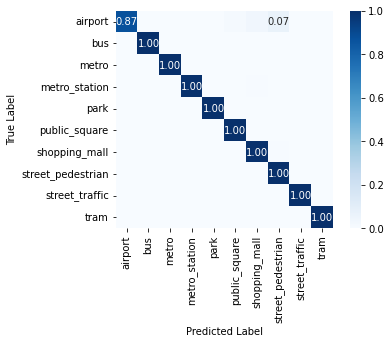

<Figure size 2400x1600 with 0 Axes>

In [75]:
# Create Confusion matrix as we've done before
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print(np.sum(y_pred_val==y_val_labels))
Overall_accuracy = np.sum(y_pred_val==y_val_labels)/probs.shape[0]
print("overall accuracy: ", Overall_accuracy)

ClassNames = ['airport', 'bus', 'metro', 'metro_station', 'park', 'public_square',
 'shopping_mall', 'street_pedestrian', 'street_traffic', 'tram']

# Calculate row sums to use for percentages
conf_matrix = confusion_matrix(y_val_labels,y_pred_val)
row_sums = conf_matrix.sum(axis=1)

# Calculate percentages
percentages = (conf_matrix.T / row_sums).T  # Transpose for division, then transpose back

# Format percentages as strings with '%' symbol
annot_data = [['{:.2f}'.format(val) for val in row] for row in percentages]
annot_data = [['' if float(val <= 0.04) else '{:.2f}'.format(val) for val in row] for row in percentages]

annot_kws = {'size': 10}
ax = sns.heatmap(percentages, xticklabels=ClassNames, yticklabels=ClassNames, annot=annot_data, fmt='', square=True, cmap='Blues', annot_kws=annot_kws)
ax.set_xlabel('Predicted Label')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.set_ylabel('True Label')

plt.figure(dpi=400)
plt.subplots_adjust(left=0.2, bottom=0.35)
plt.show()

In [70]:
from sklearn.decomposition import PCA

# Use probs to create
intermediate_output = probs
y_val = y_val_labels

pca2 = PCA(2)
pca2.fit(intermediate_output)
embeddings2 = pca2.transform(intermediate_output)
print(embeddings2)

print(y_val)

[[-4.92419856  1.02673557]
 [ 6.02006279 -1.52119703]
 [-0.53780027  3.77222057]
 ...
 [ 6.70176366 -1.49652262]
 [ 6.73599198 -0.59874264]
 [ 5.72814201 -0.73015847]]
[7 2 4 ... 9 9 9]


0
1
2
3
4
5
6
7
8
9


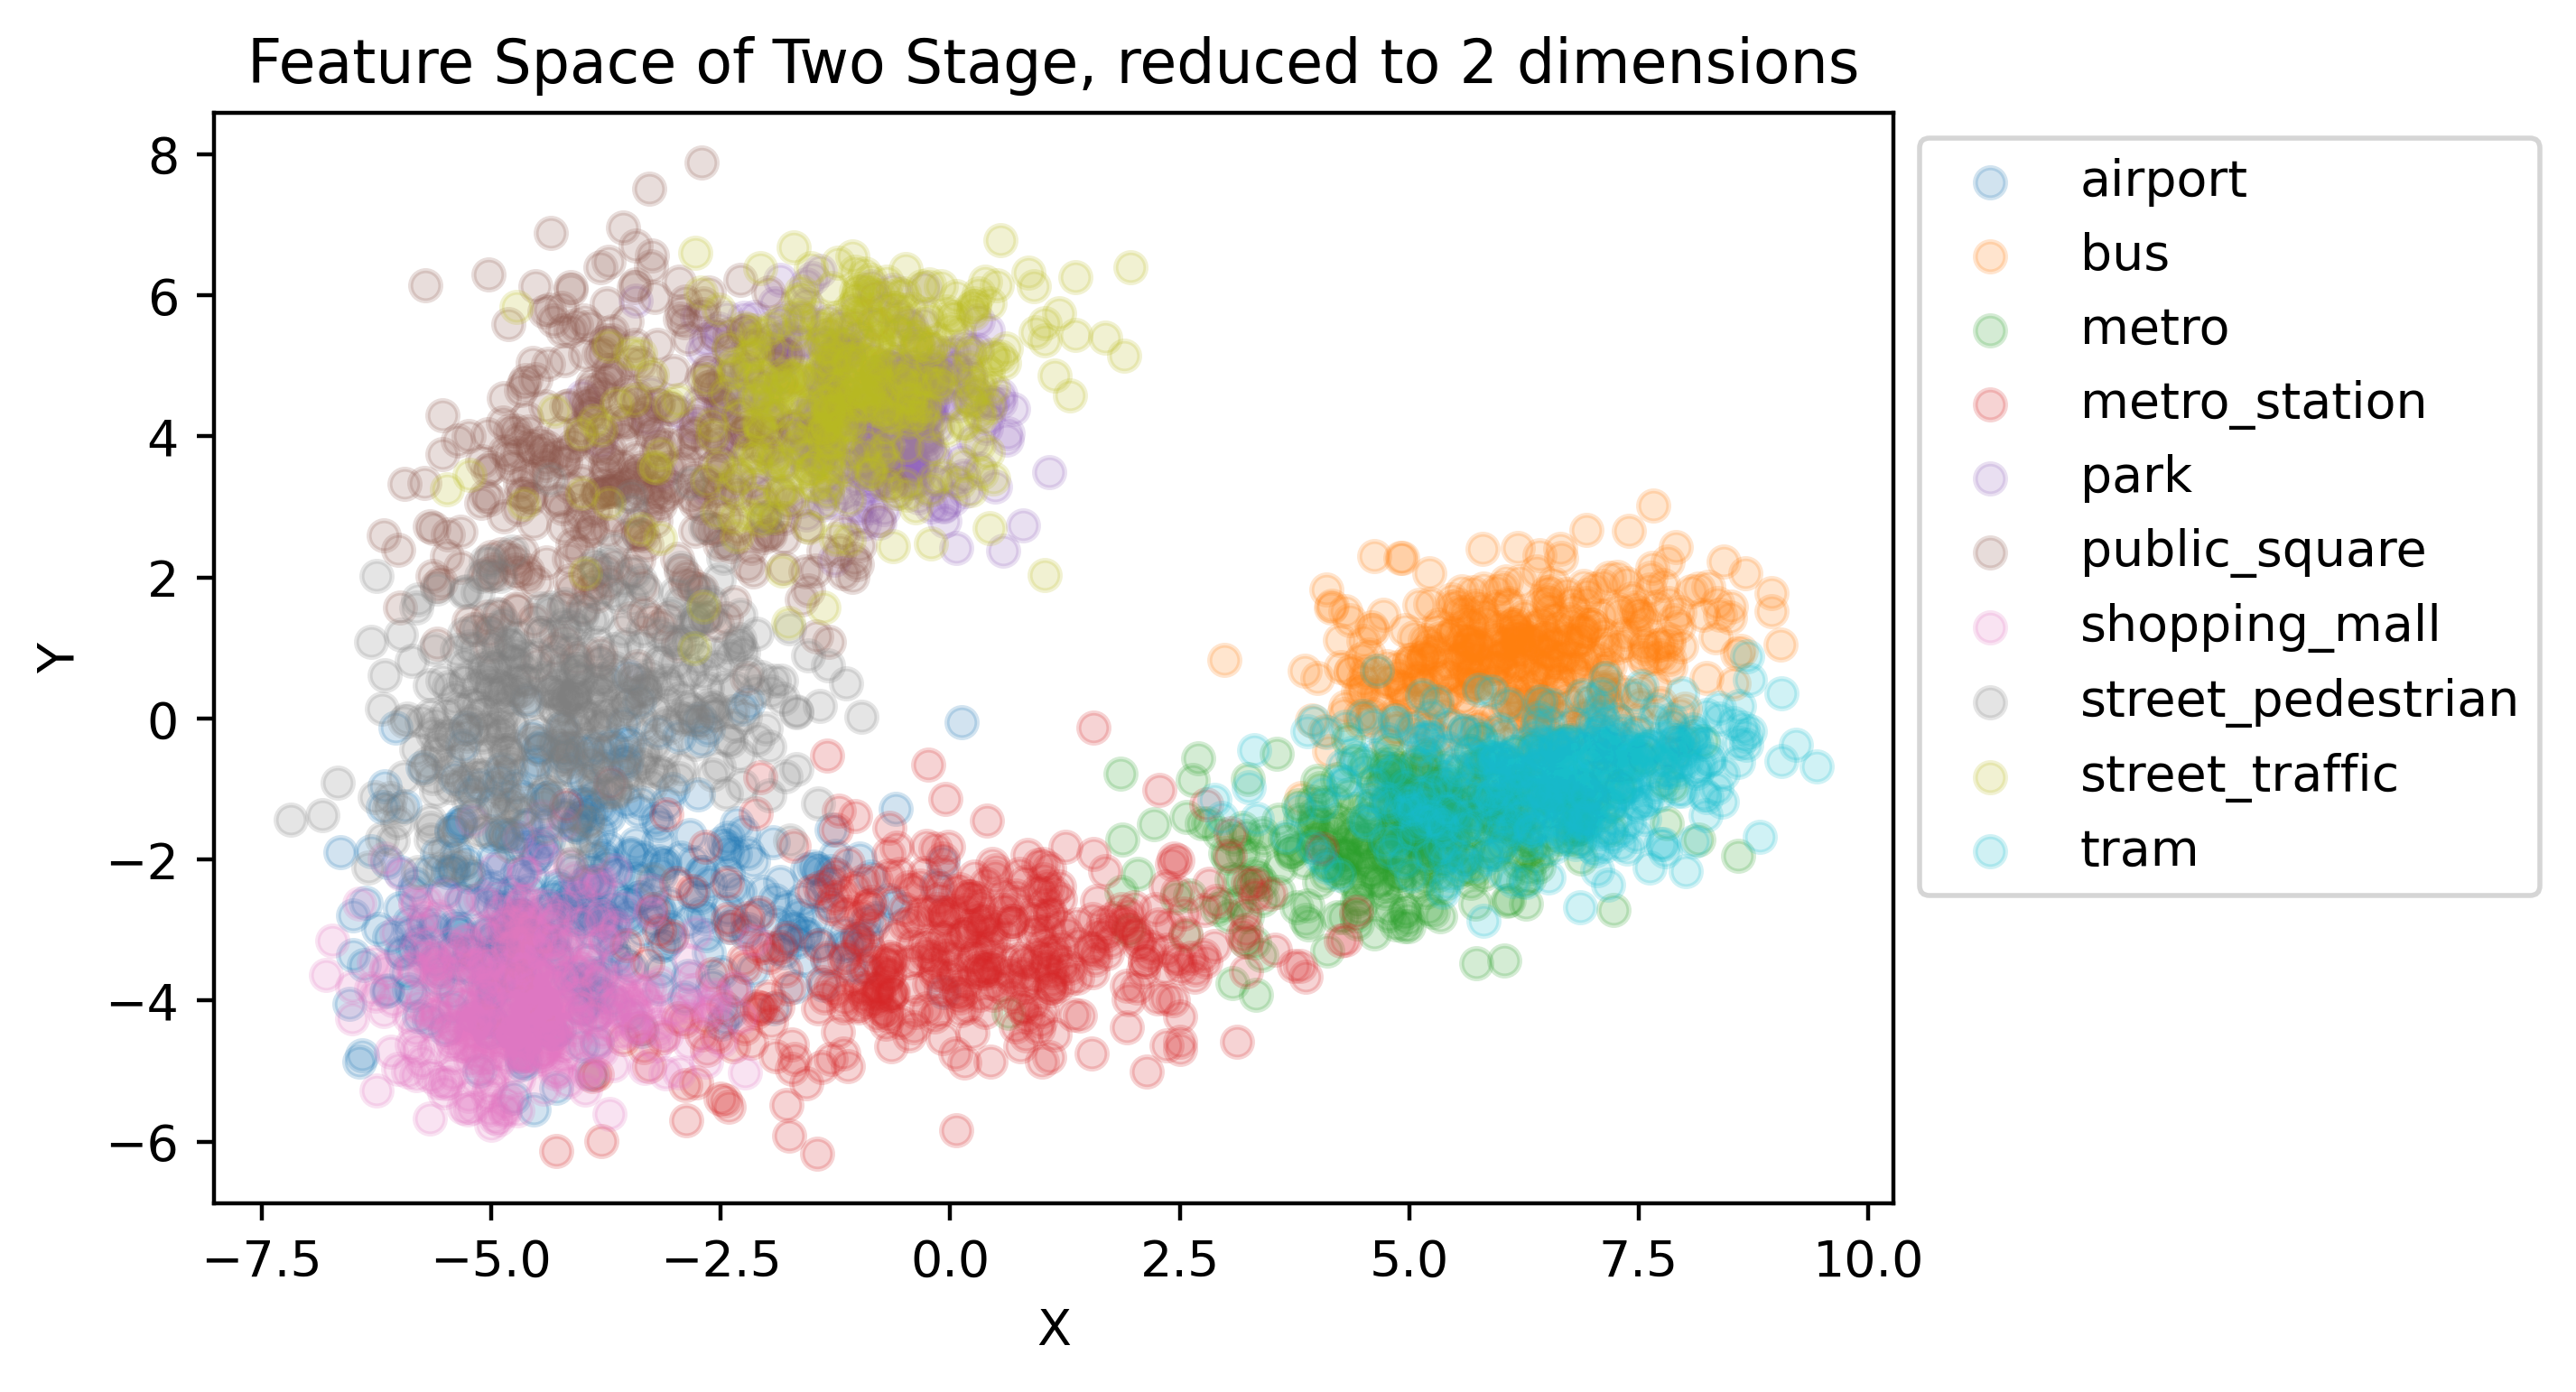

In [77]:
import matplotlib.patches as mpatches
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

data = embeddings2
ids = y_val

color_list = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]

plt.figure(dpi=400)
#plt.figure(figsize=(60,18))

for i in range(10):
    class_data = embeddings2[ids == i]
    plt.scatter(class_data[:, 0], class_data[:, 1], color=color_list[i], alpha=0.2, label=ClassNames[i])

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Feature Space of Two Stage, reduced to 2 dimensions')

# Create custom legend handler to make legend elements fully opaque
def custom_legend_handler(legend, orig_handle, color):
    new_handle = mpatches.Patch(facecolor=color, edgecolor='none', alpha=1)
    return new_handle

# Add legend with custom handler
plt.legend(handler_map={plt.scatter: custom_legend_handler},loc='upper right', bbox_to_anchor=(1.4, 1))

# Show the plot
plt.show()